## Import dependies/libraries

In [1]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import nltk
import seaborn as sns
import string
from sklearn.preprocessing import LabelEncoder


# Download NLTK stopwords if not already downloaded
nltk.download('stopwords')

# Import stopwords
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to C:\Users\Swetanshu
[nltk_data]     Pandey\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Load Data

In [2]:
df = pd.read_csv(r"bbc.csv")

##  1) Explore the dataset and describe the data, clean it up if necessary:

In [3]:
# Display the first few rows of the dataset to understand its structure
df.head()

,position,channel_id,channel_title,video_id,published_at,video_title,video_description,video_category_id,video_category_label,duration,duration_sec,dimension,definition,caption,licensed_content,view_count,like_count,dislike_count,favorite_count,comment_count
0,1,UCCj956IF62FbT7Gouszaj9w,BBC,8qH0pGdjB_U,2020-08-13T15:00:02Z,Colin Robinson's Origins of the Species - What...,Subscribe and 🔔 to OFFICIAL BBC YouTube 👉 http...,24,Entertainment,PT5M23S,323,2d,hd,False,1.0,738,76.0,7.0,0,4.0
1,2,UCCj956IF62FbT7Gouszaj9w,BBC,lqeS-rOoBSw,2020-08-13T14:30:04Z,Maisie Smith and Zack Morris on EastEnders' la...,Subscribe and 🔔 to OFFICIAL BBC YouTube 👉 http...,24,Entertainment,PT3M15S,195,2d,hd,False,1.0,512,55.0,9.0,0,13.0
2,3,UCCj956IF62FbT7Gouszaj9w,BBC,JMfkBavl1ks,2020-08-13T05:50:21Z,A-level results to arrive in year with no exam...,Subscribe and 🔔 to OFFICIAL BBC YouTube 👉 http...,27,Education,PT14M48S,888,2d,hd,False,NaN,19888,326.0,50.0,0,128.0
3,4,UCCj956IF62FbT7Gouszaj9w,BBC,T_6RRmkLOSs,2020-08-12T13:00:13Z,8 signs you're in survival mode and how to sta...,Subscribe and 🔔 to OFFICIAL BBC YouTube 👉 http...,27,Education,PT3M50S,230,2d,hd,False,1.0,14515,324.0,532.0,0,282.0
4,5,UCCj956IF62FbT7Gouszaj9w,BBC,3-mayD_9Yg8,2020-08-12T11:00:02Z,The secret Heathrow lounge that costs £2700 ju...,Subscribe and 🔔 to OFFICIAL BBC YouTube 👉 http...,24,Entertainment,PT1M52S,112,2d,hd,False,1.0,15644,331.0,14.0,0,22.0


In [4]:
# shape of Data
df.shape

(12456, 20)

In [5]:
# get info of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12456 entries, 0 to 12455
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   position              12456 non-null  int64  
 1   channel_id            12456 non-null  object 
 2   channel_title         12456 non-null  object 
 3   video_id              12456 non-null  object 
 4   published_at          12456 non-null  object 
 5   video_title           12456 non-null  object 
 6   video_description     12456 non-null  object 
 7   video_category_id     12456 non-null  int64  
 8   video_category_label  12456 non-null  object 
 9   duration              12456 non-null  object 
 10  duration_sec          12456 non-null  int64  
 11  dimension             12456 non-null  object 
 12  definition            12456 non-null  object 
 13  caption               12456 non-null  bool   
 14  licensed_content      11878 non-null  float64
 15  view_count         

In [6]:
# Check data types of each column
(pd.DataFrame(df.dtypes.reset_index()))

,index,0
0,position,int64
1,channel_id,object
2,channel_title,object
3,video_id,object
4,published_at,object
5,video_title,object
6,video_description,object
7,video_category_id,int64
8,video_category_label,object
9,duration,object


In [7]:
# What is the minimum and maximum value for a published time header (‘parsed_time_pub’))? Present it in a year (YYYY) format.

# Convert 'published_at' column to datetime format
df['parsed_time_pub'] = pd.to_datetime(df['published_at'])

# Find minimum and maximum published time
min_published_time = df['parsed_time_pub'].min().strftime('%Y')
max_published_time = df['parsed_time_pub'].max().strftime('%Y')

print("Minimum published time (YYYY):", min_published_time)
print("Maximum published time (YYYY):", max_published_time)

Minimum published time (YYYY): 2007
Maximum published time (YYYY): 2020


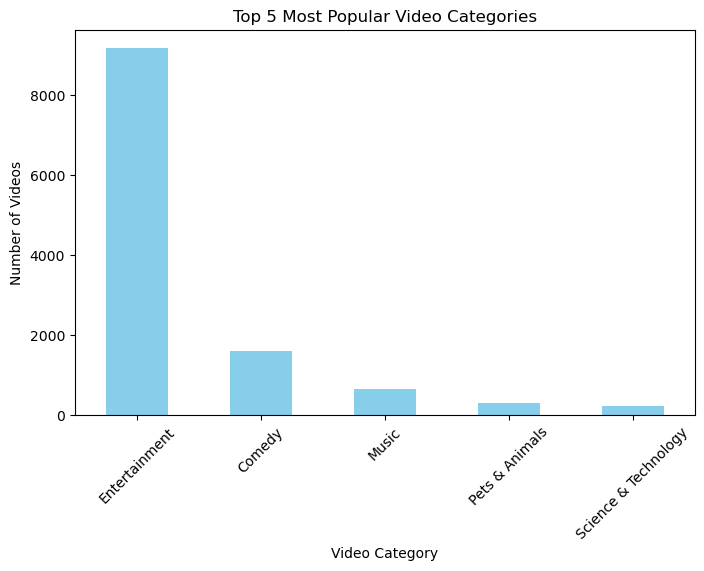

In [8]:
# Group by video category label and count the number of occurrences
category_counts = df['video_category_label'].value_counts().head(5)

# Visualize the result
plt.figure(figsize=(8, 5))
category_counts.plot(kind='bar', color='skyblue')
plt.title('Top 5 Most Popular Video Categories')
plt.xlabel('Video Category')
plt.ylabel('Number of Videos')
plt.xticks(rotation=45)

# Set x-axis tick labels to video categories
plt.xticks(ticks=range(len(category_counts.index)), labels=category_counts.index)

plt.show()

In [9]:
# identify missing dataset

def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return tt

missing_data(df)

,Total,Percent,Types
position,0,0.000000,int64
channel_id,0,0.000000,object
channel_title,0,0.000000,object
video_id,0,0.000000,object
published_at,0,0.000000,object
video_title,0,0.000000,object
video_description,0,0.000000,object
video_category_id,0,0.000000,int64
video_category_label,0,0.000000,object
duration,0,0.000000,object


In [10]:
# Show unique values

def unique_values(data):
    total = data.count()
    tt = pd.DataFrame(total)
    tt.columns = ['Total']
    uniques = []
    for col in data.columns:
        unique = data[col].nunique()
        uniques.append(unique)
    tt['Uniques'] = uniques
    return tt

unique_values(df)

,Total,Uniques
position,12456,12456
channel_id,12456,1
channel_title,12456,1
video_id,12456,12456
published_at,12456,11973
video_title,12456,12421
video_description,12456,11778
video_category_id,12456,15
video_category_label,12456,15
duration,12456,913


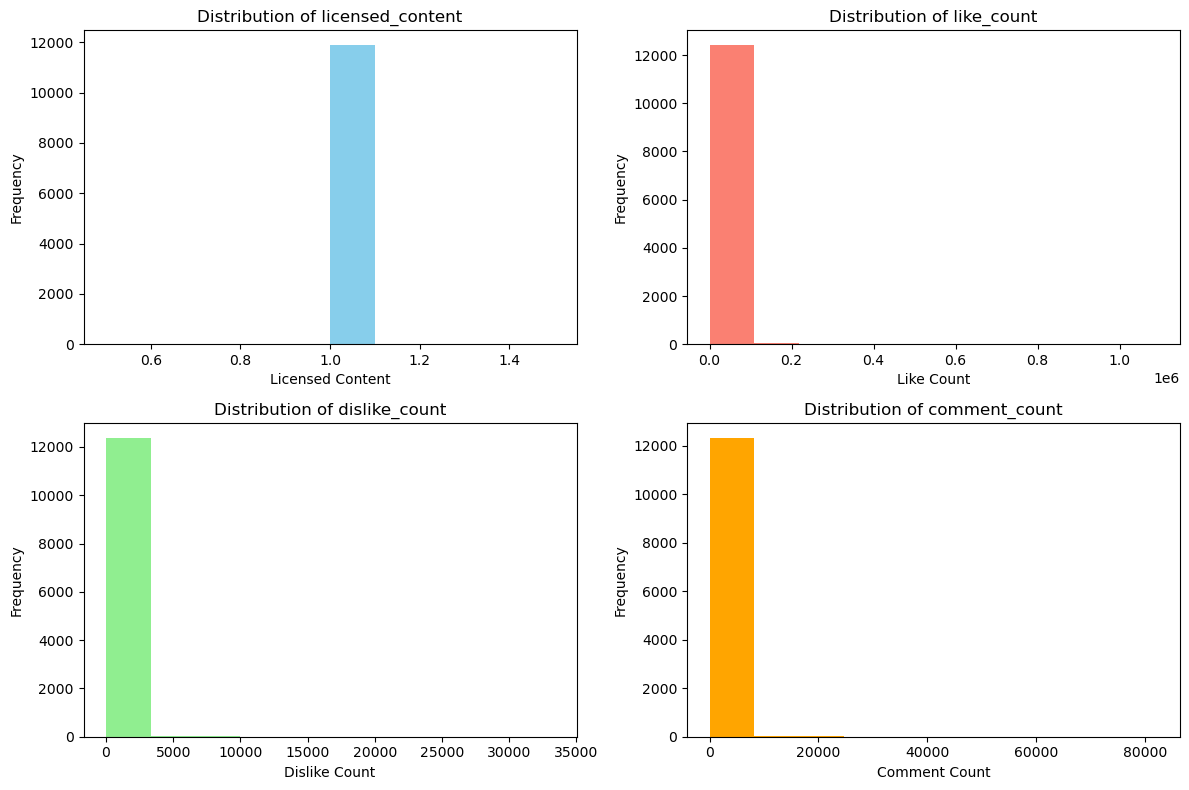

In [11]:
fig, axes = plt.subplots(2,2, figsize=(12, 8))

# Plot histograms
df['licensed_content'].plot(kind='hist', ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Distribution of licensed_content')
axes[0, 0].set_xlabel('Licensed Content')
axes[0, 0].set_ylabel('Frequency')

df['like_count'].plot(kind='hist', ax=axes[0, 1], color='salmon')
axes[0, 1].set_title('Distribution of like_count')
axes[0, 1].set_xlabel('Like Count')
axes[0, 1].set_ylabel('Frequency')

df['dislike_count'].plot(kind='hist', ax=axes[1, 0], color='lightgreen')
axes[1, 0].set_title('Distribution of dislike_count')
axes[1, 0].set_xlabel('Dislike Count')
axes[1, 0].set_ylabel('Frequency')

df['comment_count'].plot(kind='hist', ax=axes[1, 1], color='orange')
axes[1, 1].set_title('Distribution of comment_count')
axes[1, 1].set_xlabel('Comment Count')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [12]:
# Fill missing values
df['licensed_content'].fillna(0, inplace=True)
df['like_count'].fillna(df['like_count'].median(), inplace=True)
df['dislike_count'].fillna(df['dislike_count'].median(), inplace=True)
df['comment_count'].fillna(df['comment_count'].median(), inplace=True)

## 2) Slice the dataset by cutting the following columns:

In [13]:
# SLicing the dataset
df = df.drop(columns=["published_at", "video_category_id", "duration", "dimension", "licensed_content", "favorite_count"])

In [14]:
# Defining a here function to clean the video titles
def clean_video_title(title):
    # Remove punctuation
    title = title.translate(str.maketrans('', '', string.punctuation))
    
    # Remove digits
    title = ''.join([i for i in title if not i.isdigit()])
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    title = ' '.join([word for word in title.split() if word.lower() not in stop_words])
    
    # Remove specific strings
    strings_to_remove = ['bbc one', 'bbc two', 'bbc three', 'bbc', 'part', 'episode', 'series', 'preview', 'show']
    for s in strings_to_remove:
        title = title.replace(s, '')
    
    return title.strip()

# Apply the cleaning function to the 'video_title' column
df['video_title_clean'] = df['video_title'].apply(clean_video_title)

## 3) Find the top 5 keywords from the newly generated ‘video_title_clean’ header for each year represented in the dataset.

In [15]:
# Apply the function to create a new 'year' column
df['year'] = df['parsed_time_pub'].dt.year

# Group the DataFrame by year
grouped = df.groupby('year')

In [16]:
# Define a function to extract keywords - here not considering emojis
def extract_top_keywords(titles):
    all_words = ' '.join(titles).split()  # Combine all titles and split into words
    all_words = (word for word in all_words if word[:1].isalpha()) # removing any emojis 
    word_count = Counter(all_words)  # Count occurrences of each word
    top_keywords = word_count.most_common(5)  # Get the top 5 keywords
    return [keyword[0] for keyword in top_keywords]

# Find top 5 keywords for each year
top_keywords_by_year = {}
for year, group in grouped:
    top_keywords_by_year[year] = extract_top_keywords(group['video_title_clean'])

# Print the top 5 keywords for each year
for year, keywords in top_keywords_by_year.items():
    print(f"Year {year}: {keywords}")

Year 2007: ['BBC', 'One', 'Two', 'Show', 'Strictly']
Year 2008: ['BBC', 'One', 'Two', 'Three', 'Dancing']
Year 2009: ['BBC', 'One', 'Preview', 'Episode', 'Three']
Year 2010: ['BBC', 'One', 'Episode', 'Preview', 'Series']
Year 2011: ['BBC', 'One', 'Episode', 'Series', 'Two']
Year 2012: ['BBC', 'One', 'Episode', 'Series', 'Voice']
Year 2013: ['BBC', 'One', 'Episode', 'Series', 'Preview']
Year 2014: ['BBC', 'One', 'Episode', 'Series', 'Two']
Year 2015: ['BBC', 'Episode', 'One', 'Series', 'Two']
Year 2016: ['BBC', 'One', 'Episode', 'Preview', 'Series']
Year 2017: ['BBC', 'One', 'Episode', 'Show', 'Two']
Year 2018: ['BBC', 'One', 'Graham', 'Norton', 'Together']
Year 2019: ['BBC', 'Show', 'Graham', 'Norton', 'Dancer']
Year 2020: ['BBC', 'Coronavirus', 'Covid', 'UK', 'News']


In [17]:
# Define a function to extract keywords - here considering emojis
def extract_top_keywords(titles):
    all_words = ' '.join(titles).split()  # Combine all titles and split into words
    word_count = Counter(all_words)  # Count occurrences of each word
    top_keywords = word_count.most_common(5)  # Get the top 5 keywords
    return [keyword[0] for keyword in top_keywords]

# Find top 5 keywords for each year
top_keywords_by_year = {}
for year, group in grouped:
    top_keywords_by_year[year] = extract_top_keywords(group['video_title_clean'])

# Print the top 5 keywords for each year
for year, keywords in top_keywords_by_year.items():
    print(f"Year {year}: {keywords}")

Year 2007: ['BBC', 'One', 'Two', 'Show', 'Strictly']
Year 2008: ['BBC', 'One', 'Two', 'Three', 'Dancing']
Year 2009: ['BBC', 'One', 'Preview', 'Episode', 'Three']
Year 2010: ['BBC', 'One', 'Episode', 'Preview', 'Series']
Year 2011: ['BBC', 'One', 'Episode', 'Series', 'Two']
Year 2012: ['BBC', 'One', 'Episode', 'Series', 'Voice']
Year 2013: ['BBC', 'One', 'Episode', 'Series', 'Preview']
Year 2014: ['BBC', 'One', 'Episode', 'Series', 'Two']
Year 2015: ['BBC', 'Episode', 'One', 'Series', 'Two']
Year 2016: ['BBC', 'One', 'Episode', 'Preview', 'Series']
Year 2017: ['BBC', 'One', 'Episode', 'Show', 'Two']
Year 2018: ['BBC', 'One', 'Graham', 'Norton', 'Together']
Year 2019: ['BBC', 'Show', 'Graham', 'Norton', 'Dancer']
Year 2020: ['BBC', 'Coronavirus', '🔴', 'Covid', 'UK']


## 4) Calculate and assign a new column 'engagement rate' for each row using the following formula: total engagements (likes, comments, dislikes) divided by the number of views per post, then multiply the result by 100 and round it up to 1 decimal.

In [18]:
# Calculate total engagements for each row
total_engagements = df['like_count'] + df['comment_count'] + df['dislike_count']

# Calculate views per post
views_per_post = df['view_count']

# Calculate engagement rate
engagement_rate = (total_engagements / views_per_post) * 100

# Round the engagement rate to 1 decimal place
engagement_rate = engagement_rate.round(1)

# Assign the calculated engagement rate to a new column
df['engagement_rate'] = engagement_rate

# Display the DataFrame with the new 'engagement_rate' column
df.head()

,position,channel_id,channel_title,video_id,video_title,video_description,video_category_label,duration_sec,definition,caption,view_count,like_count,dislike_count,comment_count,parsed_time_pub,video_title_clean,year,engagement_rate
0,1,UCCj956IF62FbT7Gouszaj9w,BBC,8qH0pGdjB_U,Colin Robinson's Origins of the Species - What...,Subscribe and 🔔 to OFFICIAL BBC YouTube 👉 http...,Entertainment,323,hd,False,738,76.0,7.0,4.0,2020-08-13 15:00:02+00:00,Colin Robinsons Origins Species Shadows BBC,2020,11.8
1,2,UCCj956IF62FbT7Gouszaj9w,BBC,lqeS-rOoBSw,Maisie Smith and Zack Morris on EastEnders' la...,Subscribe and 🔔 to OFFICIAL BBC YouTube 👉 http...,Entertainment,195,hd,False,512,55.0,9.0,13.0,2020-08-13 14:30:04+00:00,Maisie Smith Zack Morris EastEnders latest tee...,2020,15.0
2,3,UCCj956IF62FbT7Gouszaj9w,BBC,JMfkBavl1ks,A-level results to arrive in year with no exam...,Subscribe and 🔔 to OFFICIAL BBC YouTube 👉 http...,Education,888,hd,False,19888,326.0,50.0,128.0,2020-08-13 05:50:21+00:00,Alevel results arrive year exams Covid Top sto...,2020,2.5
3,4,UCCj956IF62FbT7Gouszaj9w,BBC,T_6RRmkLOSs,8 signs you're in survival mode and how to sta...,Subscribe and 🔔 to OFFICIAL BBC YouTube 👉 http...,Education,230,hd,False,14515,324.0,532.0,282.0,2020-08-12 13:00:13+00:00,signs youre survival mode start living BBC,2020,7.8
4,5,UCCj956IF62FbT7Gouszaj9w,BBC,3-mayD_9Yg8,The secret Heathrow lounge that costs £2700 ju...,Subscribe and 🔔 to OFFICIAL BBC YouTube 👉 http...,Entertainment,112,hd,False,15644,331.0,14.0,22.0,2020-08-12 11:00:02+00:00,secret Heathrow lounge costs £ get QI BBC,2020,2.3


## 5) Calculate the length of characters in ‘video_title_clean’ and assign it to ‘title_len’ column.

In [19]:
# Calculate the length of characters in 'video_title_clean' and assign it to a new column
df['title_len'] = df['video_title_clean'].apply(len)

# Display the DataFrame with the new 'title_len' column
df.head()

,position,channel_id,channel_title,video_id,video_title,video_description,video_category_label,duration_sec,definition,caption,view_count,like_count,dislike_count,comment_count,parsed_time_pub,video_title_clean,year,engagement_rate,title_len
0,1,UCCj956IF62FbT7Gouszaj9w,BBC,8qH0pGdjB_U,Colin Robinson's Origins of the Species - What...,Subscribe and 🔔 to OFFICIAL BBC YouTube 👉 http...,Entertainment,323,hd,False,738,76.0,7.0,4.0,2020-08-13 15:00:02+00:00,Colin Robinsons Origins Species Shadows BBC,2020,11.8,43
1,2,UCCj956IF62FbT7Gouszaj9w,BBC,lqeS-rOoBSw,Maisie Smith and Zack Morris on EastEnders' la...,Subscribe and 🔔 to OFFICIAL BBC YouTube 👉 http...,Entertainment,195,hd,False,512,55.0,9.0,13.0,2020-08-13 14:30:04+00:00,Maisie Smith Zack Morris EastEnders latest tee...,2020,15.0,59
2,3,UCCj956IF62FbT7Gouszaj9w,BBC,JMfkBavl1ks,A-level results to arrive in year with no exam...,Subscribe and 🔔 to OFFICIAL BBC YouTube 👉 http...,Education,888,hd,False,19888,326.0,50.0,128.0,2020-08-13 05:50:21+00:00,Alevel results arrive year exams Covid Top sto...,2020,2.5,62
3,4,UCCj956IF62FbT7Gouszaj9w,BBC,T_6RRmkLOSs,8 signs you're in survival mode and how to sta...,Subscribe and 🔔 to OFFICIAL BBC YouTube 👉 http...,Education,230,hd,False,14515,324.0,532.0,282.0,2020-08-12 13:00:13+00:00,signs youre survival mode start living BBC,2020,7.8,42
4,5,UCCj956IF62FbT7Gouszaj9w,BBC,3-mayD_9Yg8,The secret Heathrow lounge that costs £2700 ju...,Subscribe and 🔔 to OFFICIAL BBC YouTube 👉 http...,Entertainment,112,hd,False,15644,331.0,14.0,22.0,2020-08-12 11:00:02+00:00,secret Heathrow lounge costs £ get QI BBC,2020,2.3,41


## 6) Assign a dichotomized score for engagement rate in a separate column, where ‘top 50%’ (engagement rate >=0.6) is represented by 1 , and ‘bottom 50%’ is represented by 0.

In [20]:
# Calculate the engagement rate threshold for top 50%
engagement_rate_threshold = df['engagement_rate'].quantile(0.5)

# Assign a dichotomized score based on engagement rate
df['engagement_score'] = (df['engagement_rate'] >= engagement_rate_threshold).astype(int)

# Display the DataFrame with the new 'engagement_score' column
df.head()

,position,channel_id,channel_title,video_id,video_title,video_description,video_category_label,duration_sec,definition,caption,view_count,like_count,dislike_count,comment_count,parsed_time_pub,video_title_clean,year,engagement_rate,title_len,engagement_score
0,1,UCCj956IF62FbT7Gouszaj9w,BBC,8qH0pGdjB_U,Colin Robinson's Origins of the Species - What...,Subscribe and 🔔 to OFFICIAL BBC YouTube 👉 http...,Entertainment,323,hd,False,738,76.0,7.0,4.0,2020-08-13 15:00:02+00:00,Colin Robinsons Origins Species Shadows BBC,2020,11.8,43,1
1,2,UCCj956IF62FbT7Gouszaj9w,BBC,lqeS-rOoBSw,Maisie Smith and Zack Morris on EastEnders' la...,Subscribe and 🔔 to OFFICIAL BBC YouTube 👉 http...,Entertainment,195,hd,False,512,55.0,9.0,13.0,2020-08-13 14:30:04+00:00,Maisie Smith Zack Morris EastEnders latest tee...,2020,15.0,59,1
2,3,UCCj956IF62FbT7Gouszaj9w,BBC,JMfkBavl1ks,A-level results to arrive in year with no exam...,Subscribe and 🔔 to OFFICIAL BBC YouTube 👉 http...,Education,888,hd,False,19888,326.0,50.0,128.0,2020-08-13 05:50:21+00:00,Alevel results arrive year exams Covid Top sto...,2020,2.5,62,1
3,4,UCCj956IF62FbT7Gouszaj9w,BBC,T_6RRmkLOSs,8 signs you're in survival mode and how to sta...,Subscribe and 🔔 to OFFICIAL BBC YouTube 👉 http...,Education,230,hd,False,14515,324.0,532.0,282.0,2020-08-12 13:00:13+00:00,signs youre survival mode start living BBC,2020,7.8,42,1
4,5,UCCj956IF62FbT7Gouszaj9w,BBC,3-mayD_9Yg8,The secret Heathrow lounge that costs £2700 ju...,Subscribe and 🔔 to OFFICIAL BBC YouTube 👉 http...,Entertainment,112,hd,False,15644,331.0,14.0,22.0,2020-08-12 11:00:02+00:00,secret Heathrow lounge costs £ get QI BBC,2020,2.3,41,1


## 7) Encode ‘video category labels' and ‘definition’ labels to numeric values.

In [21]:
# Create LabelEncoder objects
category_encoder = LabelEncoder()
definition_encoder = LabelEncoder()

# Fit and transform the 'video_category_label' column
df['video_category_encoded'] = category_encoder.fit_transform(df['video_category_label'])

# Fit and transform the 'definition' column
df['definition_encoded'] = definition_encoder.fit_transform(df['definition'])

## 8) Visualize a correlation between following headers: definition, duration, dichotomized score, parsed_time_pub, engagement rate, title length, video_category_label.

C:\Users\Swetanshu Pandey\AppData\Local\Temp\ipykernel_14272\2642008056.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df[columns_to_visualize].corr()


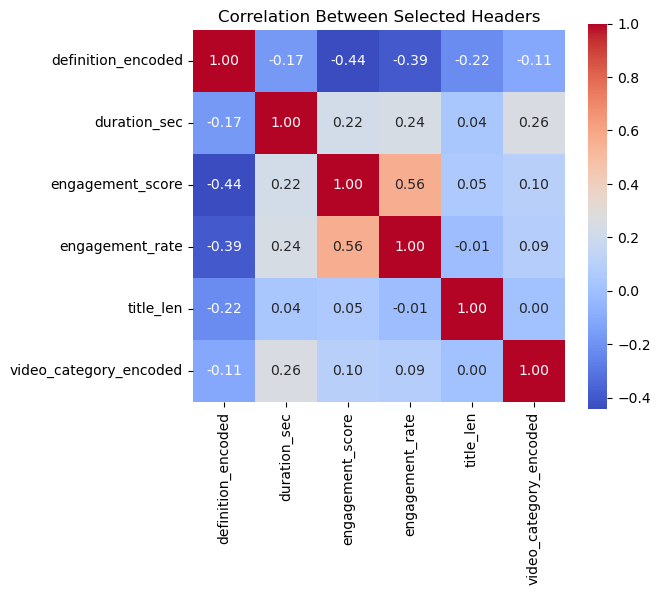

In [22]:
# Select the relevant columns
columns_to_visualize = ['definition_encoded', 'duration_sec', 'engagement_score', 'parsed_time_pub', 'engagement_rate', 'title_len', 'video_category_encoded']

# Calculate the correlation matrix
correlation_matrix = df[columns_to_visualize].corr()

# Plot the correlation heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Between Selected Headers')
plt.show()

## 9) Describe in your own words what correlations you observe there. Put it in a comment in the code.

##### About Correlation:-

##### 1. Strength of Correlation:
##### - Correlation coefficients (r) range from -1 to 1.
##### - The closer the absolute value of the correlation coefficient is to 1, the stronger the correlation.
##### - A correlation coefficient of 1 or -1 indicates a perfect linear relationship.
##### - A correlation coefficient close to 0 indicates a weak or no linear relationship.
##### 2. Direction of Correlation:
##### - A positive correlation (r > 0) means that as one variable increases, the other variable also tends to increase.
##### - A negative correlation (r < 0) means that as one variable increases, the other variable tends to decrease.
##### 3. Interpretation:
##### - Strong positive correlation: The variables move in the same direction and the correlation coefficient is close to +1 (e.g., 0.8 to 1.0).
##### - Weak positive correlation: The variables move in the same direction, but the correlation coefficient is closer to 0 than to +1 (e.g., 0.2 to 0.6).
##### - Strong negative correlation: The variables move in opposite directions and the correlation coefficient is close to -1 (e.g., -0.8 to -1.0).
##### - Weak negative correlation: The variables move in opposite directions, but the correlation coefficient is closer to 0 than to -1 (e.g., -0.2 to -0.6).
##### - No correlation: The correlation coefficient is close to 0 (e.g., -0.2 to 0.2).

In [23]:
# So we can see that:-
# 1. Duration_sec and definition_encoded don't have any correlation
# 2. engagement_score and definition_encoded are weak negatively correlated. (A negative correlation (r < 0) means that as one variable increases, the other variable tends to decrease.)
# 3. engagement_rate and definition_encoded are weak negatively correlated.
# 4. title_len and definition_encoded are weak negatively correlated.
# 5. video_category_encoded and definition_encoded don't have any correlation


# 6. Duration_sec and engagement_score are weak positively correlated.  (Weak positive correlation: The variables move in the same direction, but the correlation coefficient is closer to 0 than to +1 (e.g., 0.2 to 0.6).)
# 7. Duration_sec and engagement_rate are weak positively correlated.
# 8. title_len and Duration_sec don't have any correlation.
# 9. Duration_sec and video_category_encoded are weak positively correlated.


# 10. engagement_score and engagement_rate are weak positively correlated.
# 11. engagement_score and title_len don't have any correlation.
# 12. engagement_score and video_category_encoded don't have any correlation.


# 13. engagement_rate and title_len don't have any correlation.
# 14. engagement_rate and video_category_encoded don't have any correlation.


# 15. title_len and video_category_encoded don't have any correlation.